In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ast import literal_eval
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, precision_score
from dmba import classificationSummary, liftChart

In [2]:
movies = pd.read_csv('../data/iac_dataset/modeling_data.csv')

features = ['keywords', 'cast', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(literal_eval)

# Preprocessing prior to modeling

In [3]:
movies['director'] = movies['director'].astype(str).str.replace('.', '')
movies['director'] = movies['director'].astype(str).str.replace(' ', '_')

movies['prod_company'] = movies['prod_company'].astype(str).str.replace('.', '')
movies['prod_company'] = movies['prod_company'].astype(str).str.replace(' ', '_')

/var/folders/ll/snp8v88x0dz1nl1l9yq19m680000gn/T/ipykernel_74674/453367950.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['director'] = movies['director'].astype(str).str.replace('.', '')
/var/folders/ll/snp8v88x0dz1nl1l9yq19m680000gn/T/ipykernel_74674/453367950.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  movies['prod_company'] = movies['prod_company'].astype(str).str.replace('.', '')


In [4]:
movies['label'] = pd.cut(movies.avg_rating, bins=[0,3.4,5],labels=[0,1])

In [5]:
X = movies[['genres','cast','director','prod_company','popularity','revenue_millions']]
y = movies[['avg_rating','label','title']]

In [6]:
# creating dummies
genres_cat = X.genres.str.join('|').str.get_dummies().add_prefix('genres_')
X = pd.concat([X, genres_cat], axis=1)
X = X.drop(columns='genres')

In [7]:
# creating dummies
cast_cat = X.cast.str.join('|').str.get_dummies().add_prefix('cast_')
X = pd.concat([X, cast_cat], axis=1)
X = X.drop(columns='cast')

In [8]:
keyword_cat = X.director.str.get_dummies().add_prefix('director_')
X = pd.concat([X, keyword_cat], axis=1)
X = X.drop(columns='director')

In [9]:
keyword_cat = X.prod_company.str.get_dummies().add_prefix('prod_company_')
X = pd.concat([X, keyword_cat], axis=1)
X = X.drop(columns='prod_company')

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y,test_size=0.20, random_state = 2022)

In [11]:
movie_knn = KNeighborsClassifier(n_neighbors=24, metric='cosine')
movie_knn.fit(X_train, y_train['label'])

y_pred = movie_knn.predict(X_val)

# Comparing Results
classificationSummary(y_val.label, y_pred)
print(f'precision: {precision_score(y_val.label, y_pred, zero_division=0)}')
print(f'recall: {recall_score(y_val.label, y_pred, zero_division=1)}')

Confusion Matrix (Accuracy 0.7052)

       Prediction
Actual    0    1
     0 1890  331
     1  575  277
precision: 0.4555921052631579
recall: 0.32511737089201875


In [12]:
# Training Logistic Model
movie_log = LogisticRegression( random_state=2020, max_iter=10000)
movie_log.fit(X_train, y_train['label'])

# Predicting using training set
y_pred = movie_log.predict(X_val)

# Comparing Results
classificationSummary(y_val.label, y_pred)
print(f'precision: {precision_score(y_val.label, y_pred, zero_division=0)}')
print(f'recall: {recall_score(y_val.label, y_pred, zero_division=1)}')

Confusion Matrix (Accuracy 0.7410)

       Prediction
Actual    0    1
     0 1980  241
     1  555  297
precision: 0.5520446096654275
recall: 0.3485915492957746


In [20]:
movie_tree = DecisionTreeClassifier(random_state=2020)
movie_tree.fit(X_train, y_train['label'])
y_pred = movie_tree.predict(X_val)

# Comparing Results
classificationSummary(y_val.label, y_pred)
print(f'precision: {precision_score(y_val.label, y_pred, zero_division=0)}')
print(f'recall: {recall_score(y_val.label, y_pred, zero_division=1)}')

Confusion Matrix (Accuracy 0.7169)

       Prediction
Actual    0    1
     0 1892  329
     1  541  311
precision: 0.4859375
recall: 0.36502347417840375


In [21]:
movie_rf = RandomForestClassifier(random_state=2020)
movie_rf.fit(X_train, y_train['label'])
y_pred = movie_rf.predict(X_val)

# Comparing Results
classificationSummary(y_val.label, y_pred)
print(f'precision: {precision_score(y_val.label, y_pred, zero_division=0)}')
print(f'recall: {recall_score(y_val.label, y_pred, zero_division=1)}')

Confusion Matrix (Accuracy 0.7589)

       Prediction
Actual    0    1
     0 2143   78
     1  663  189
precision: 0.7078651685393258
recall: 0.22183098591549297


In [24]:
movie_neural = MLPClassifier(random_state=1, max_iter=300)
movie_neural.fit(X_train, y_train['label'])
y_pred = movie_neural.predict(X_val)

# Comparing Results
classificationSummary(y_val.label, y_pred)
print(f'precision: {precision_score(y_val.label, y_pred, zero_division=0)}')
print(f'recall: {recall_score(y_val.label, y_pred, zero_division=1)}')

Confusion Matrix (Accuracy 0.6830)

       Prediction
Actual    0    1
     0 1727  494
     1  480  372
precision: 0.4295612009237875
recall: 0.43661971830985913


# Lift Chart

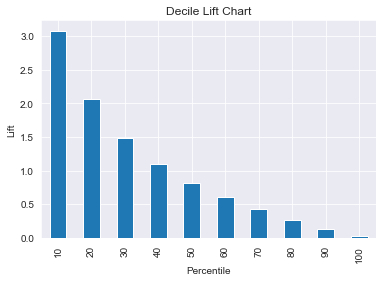

In [64]:
rf_prob = movie_rf.predict_proba(X_val)[:,1]
rf_prob = -np.sort(-rf_prob)

ax = liftChart(pd.Series(rf_prob), labelBars=False)
ax.set_ylabel('Lift')
ax.set_title('Decile Lift Chart')
plt.show()

In [82]:
print(f'Top 10 percent would yield about {round(len(rf_prob)*.10,)} movies that can be added to the collection which would be 3 times as likely to be highly rated')
print(f'Top 20 percent would yield about {round(len(rf_prob)*.20,)} movies that can be added to the collection which would be 2 times as likely to be highly rated')

Top 10 percent would yield about 307 movies that can be added to the collection which would be 3 times as likely to be highly rated
Top 20 percent would yield about 615 movies that can be added to the collection which would be 2 times as likely to be highly rated
